# Objective:

### Reducing Overfitting
1. Explore how much data augmentation works by making random transformations to training images
2. Add data augmentation to our data preprocessing
3. Add dropout to the vonvent
4. Retrain the model and evaluate loss and accuracy

## Explore Data Augmentation

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

2022-11-21 09:23:09.765594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 09:23:09.855867: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-21 09:23:09.859369: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-21 09:23:09.859378: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

- `rotation_range` is a value in degrees (0–180), a range within which to randomly rotate pictures
- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- `shear_range` is for randomly applying shearing transformations
- `zoom_range` is for randomly zooming inside pictures
- `horizontal_flip` is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures)
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift

In [2]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.421.jpg', 'cat.401.jpg', 'cat.448.jpg', 'cat.21.jpg', 'cat.108.jpg', 'cat.239.jpg', 'cat.201.jpg', 'cat.184.jpg', 'cat.587.jpg', 'cat.694.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


#### Apply the datagen transformations to a cat image from the training set to produce five random variants. Rerun the cell a few times to see fresh batches of random variants

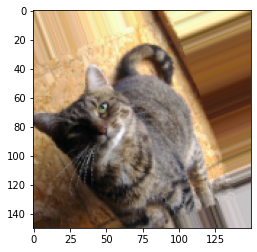

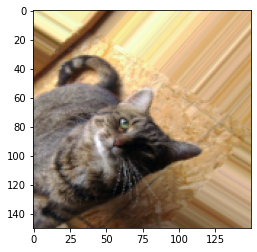

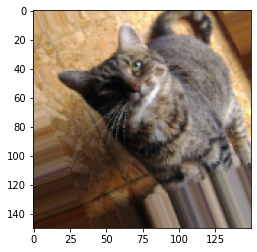

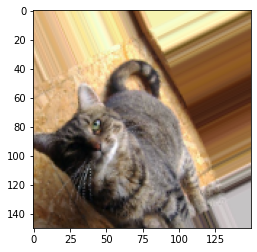

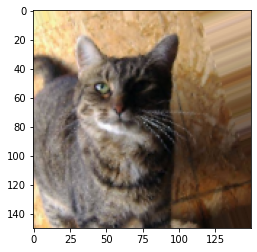

In [39]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = os.path.join(train_cats_dir, train_cat_fnames[3])
img = load_img(img_path, target_size=(150,150))
x = img_to_array(img)
x = x.reshape((1,)+x.shape)


i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 5 == 0:
        break

## Add Data Augmentation to the Preprocessing Step

In [40]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,)


val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150,150),
                                                    batch_size=20,
                                                   # Since we use binary_crossentropy loss, we need binary labels
                                                   class_mode='binary')

validation_generator = val_datagen.flow_from_directory(validation_dir,
                                                      target_size=(150,150),
                                                      batch_size=20,
                                                      class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Adding Dropout
Data Augmentation alone might not be quite enough to completely get rid of overfitting

In [41]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop

#input feature map is 150x150x3: 150x150 for the image pixels, and 3 for the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3 Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3 Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3 Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a Dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(lr=0.001),
             metrics=['acc'])

2022-11-21 10:33:43.114972: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-21 10:33:43.114987: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-21 10:33:43.114997: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nsl54): /proc/driver/nvidia/version does not exist
2022-11-21 10:33:43.115131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/nsl54/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/rmspro

## Retrain the Model

In [42]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=30,
                             validation_data=validation_generator,
                             validation_steps=50,
                             verbose=2)

Epoch 1/30


/home/nsl54/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


100/100 - 12s - loss: 0.7937 - acc: 0.5345 - val_loss: 0.6664 - val_acc: 0.6150 - 12s/epoch - 124ms/step
Epoch 2/30
100/100 - 12s - loss: 0.7057 - acc: 0.5610 - val_loss: 0.6393 - val_acc: 0.6230 - 12s/epoch - 117ms/step
Epoch 3/30
100/100 - 12s - loss: 0.6665 - acc: 0.5850 - val_loss: 0.6337 - val_acc: 0.6360 - 12s/epoch - 119ms/step
Epoch 4/30
100/100 - 12s - loss: 0.6655 - acc: 0.6075 - val_loss: 0.5877 - val_acc: 0.6940 - 12s/epoch - 123ms/step
Epoch 5/30
100/100 - 12s - loss: 0.6426 - acc: 0.6410 - val_loss: 0.8236 - val_acc: 0.5970 - 12s/epoch - 123ms/step
Epoch 6/30
100/100 - 12s - loss: 0.6392 - acc: 0.6515 - val_loss: 0.5889 - val_acc: 0.6730 - 12s/epoch - 124ms/step
Epoch 7/30
100/100 - 12s - loss: 0.6354 - acc: 0.6330 - val_loss: 0.5811 - val_acc: 0.6930 - 12s/epoch - 124ms/step
Epoch 8/30
100/100 - 12s - loss: 0.6340 - acc: 0.6485 - val_loss: 0.5567 - val_acc: 0.7170 - 12s/epoch - 124ms/step
Epoch 9/30
100/100 - 12s - loss: 0.6090 - acc: 0.6770 - val_loss: 0.5790 - val_acc:

## Evaluate the Results
Evaluate the results of model training with data augmentation and dropout

Text(0.5, 1.0, 'Training and Validation Loss')

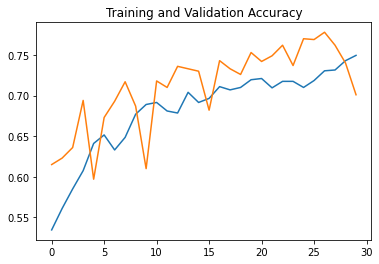

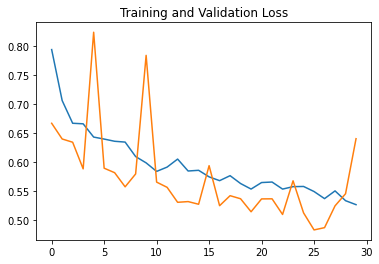

In [43]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and Validation Accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and Validation Loss')

## Clean Up


In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)